## Testing rendering pictures with [ray multiprocessing](https://docs.ray.io/en/latest/index.html)

This notebooks demonstrates how ray workers can update matplotlib figures run in a central notebook.
The pattern provides is fairly simple with a central `queue` into which all workers shift their `data`. The main (Jupyter) thread awaits for the queue to be filled and updates the respective plot

2023-02-08 23:59:18,366	INFO worker.py:1518 -- Started a local Ray instance.


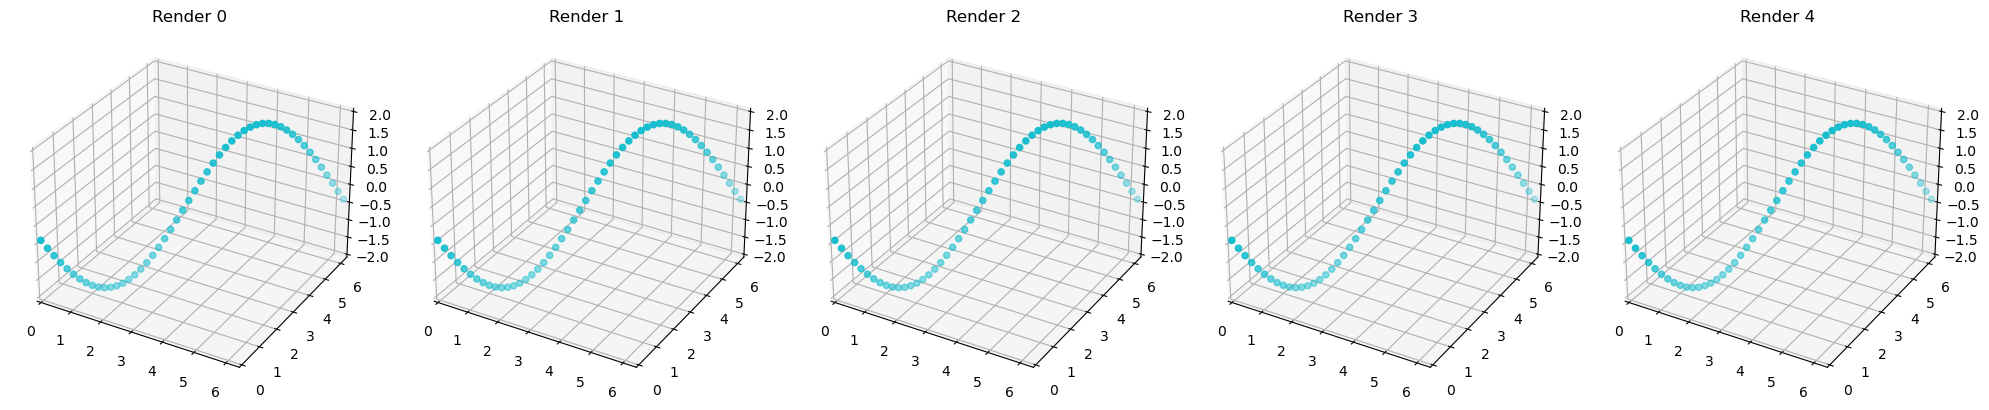

Launch
Update loop starting
(run pid=30360) Run 3 starting with a waiting time of 0.0204153
(run pid=7336) Run 0 starting with a waiting time of 0.0242224
(run pid=10328) Run 2 starting with a waiting time of 0.00085548
(run pid=29712) Run 4 starting with a waiting time of 0.0311005
(run pid=15572) Run 1 starting with a waiting time of 0.0390238
(run pid=10328) Run 2 done
(run pid=30360) Run 3 done
(run pid=7336) Run 0 done
(run pid=29712) Run 4 done
(run pid=15572) Run 1 done
Update loop done
Render is done


In [1]:
%matplotlib inline

import ray
import numpy as np
import math
import time
import io
import random
import cdxbasics.dynaplot as dynaplot
from cdxbasics.prettydict import PrettyDict as pdct
from IPython.display import display, Image
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import ray.util.queue as ray_queue


class Renderer(object):
    """
    Represents a single plot. Each plot is owned by an asynchronous process.
    """
    
    def __init__(self, fig, ix):        
        self.fig   = fig
        self.ax    = self.fig.add_subplot(projection='3d')
        self.ax.set_xlim(0.,2.*math.pi)
        self.ax.set_ylim(0.,2.*math.pi)
        self.ax.set_zlim(-2,+2)
        self.ax.set_title("Render %ld" % ix)
        self.r     = None
        self.ix    = ix
        
    def update( self, data ):
        if not self.r is None: self.r.remove()
        self.r = self.ax.scatter( data.x, data.y, data.z )


class Server(object):
    """
    Contains the shared components for our Ray driven plotting
    """

    def __init__(self):
        self.N         = 5
        self.queue     = ray_queue.Queue()
        self.fig       = dynaplot.figure()
        self.renderers = [ Renderer(self.fig, i) for i in range(self.N) ]
        self.cnt_done  = 0
        self.fig.render()

    async def update(self):
        print("Update loop starting")
        while True:
            data = self.queue.get()
            ix = data.ix
            if data.done:
                self.cnt_done += 1
                if self.cnt_done >= 5:
                    print("Update loop done")
                    return
            else:
                self.renderers[ix].update(data)
                self.fig.render()

server = Server()

@ray.remote
def run(queue, ix):
    """
    Remote function which computes the updates for each plot
    """
    x = np.linspace(0.,2.*math.pi,51)
    y = x
    w = 0.04 * random.uniform(0,1)
    print("Run %ld starting with a waiting time of %g" % (ix, w))
    for i in range(20):
        time.sleep(w)
        z = np.cos( float(i)/10.+x )+np.sin( float(i)/2.+y )
        queue.put( pdct(ix=ix,x=x,y=y,z=z,done=False) )
    queue.put( pdct(ix=ix,done=True) )
    print("Run %ld done" % ix)

"""
Launch ray'd plotting
"""
import signal
signal.signal(signal.SIGINT, signal.SIG_DFL)
print("Launch")

try:
    futures = [ run.remote(server.queue, r.ix) for r in server.renderers ]
    await server.update()
    #ray.get(futures)
except KeyboardInterrupt:
    print("Ctrl+C")
print("Render is done")

del server



